In [1]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%load_ext autoreload
%autoreload 2

###  Le processus de Poisson

Afin de simuler une entrée bruitée nous utilisons un processus de Poisson. Le processus de Poisson est un processus stochastique, qui permet la génération d'une séquence de potentiels d'action, au cours d'un certain laps de temps et, en fonction d'une probabilité d'occurence donnée. Il est dit homogène dans le cas où la probabilité d'occurence d'un potentiel d'action pour tout temps $t$ est la même, et où elle ne dépend donc pas des potentiels d'action survenus à $t-n\Delta t$,  $n$ étant un naturel non nul et $\Delta t$, le pas de temps <cite data-cite="Burkitt_2006">(Burkitt, 2006)</cite>. Une telle entrée nous servira ainsi de source d'activité pour les réseaux que nous implémenterons.

###  Effet de variations de paramètres cellulaires et non-cellulaires

Ici, nous implémentons un réseau composé de deux populations, une population A dite source et une population B. L'activité de la population A est définie par un processus de poisson homogène et la population B comporte des neurones COBA. Les deux populations sont composées chacune de deux neurones et sont connectées entre elles par une projection de type "all to all". C'est à dire que chacun des neurones de la population A est connecté à tous les neurones de la population B. 
Une première solution est de résoudre analytiquement les équation différentielles  <cite data-cite="Burkitt_2006a">(Burkitt, 2006)</cite>. Une exploration numérique de différents paramètres est ici privilégiée. Cette étude permet de tester l'effet de ces paramètres sur le taux de décharge mesuré en sortie du réseau, c'est à dire l'activité de la population B. En effet, la variation de ces paramètres sur un petit réseau de neurones permet d'observer rapidement les phénomènes qu'elle provoque. Les paramètres par défaut sont inspirés de modèles canoniques (http://neuralensemble.org/trac/PyNN/wiki/StandardModels):

Pour chaque paramètre étudié, plusieurs simulations du modèle sont lancées avec différentes valeurs du paramètre. Et pour chaque simulation, le taux de décharge neuronal moyen de la population B est récupéré. Les résultats sont alors affichés dans une courbe de taux de décharge en fonction d'une variation d'un paramètre. Les résultats de ces simulations peuvent être interpétés à partir des courbes de réponse entrée-sortie (I-F) sur les figures et de façon qualitative concernant le taux de décharge de la population B, nous observons sur une augmentation de la valeur des paramètres respectifs :

- taux de décharge de la source: une augmentation quasi-linéaire du taux de décharge,
- poids de la source : une augmentation quasi-linéaire également, 
- délai synaptique :  pas de variation,
- tau_m : une augmentation logarithmique,
- tau_syn_E : une augmentation linéaire,
- tau_syn_I : pas de variation,
- e_rev_E : une augmentation par paliers,
- e_rev_I : pas de variation,
- v_rest : une augmentation quasi linéaire,
- v_thresh : une diminution en fonction puissance,
- v_reset : une légère augmentation,
- tau_refrac : une légère diminution,
- cm : une diminution exponentielle

Ces observations confirment bien la résolution analytique des équations différentielles et permettent de contrôler que l'on est dans un bon régime <cite data-cite="Burkitt_2006a">(Burkitt, 2006)</cite>.


In [2]:
import pandas as ps
import numpy as np
import matplotlib.pyplot as plt

import pyNN.nest as sim
#import pyNN.brian as sim

from pyNN.parameters import Sequence
from pyNN.random import RandomDistribution as rnd

import os

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


### Simulation function, conductance model

TODO: il faudrait utiliser le modèle de RRNN.py

In [3]:
def simIFalphaFiring (sim_index, sim_params, cell_params):
    # === Build the network =========================================================

    sim.setup()#dt=sim_params['dt'])

    cells = sim.Population(sim_params['nb_neurons'], sim.IF_cond_alpha(**cell_params),
                           initial_values={'v': rnd('uniform', (-60.0, -50.0))},
                           label="cells")

    spike_source = sim.Population(sim_params['nb_neurons'], sim.SpikeSourcePoisson(rate=sim_params['input_rate']))

    spike_source.record('spikes')
    cells.record('spikes')
    cells[0:2].record(('v', 'gsyn_exc'))

    syn = sim.StaticSynapse(weight=sim_params['weight'], delay=sim_params['syn_delay'])
    input_conns = sim.Projection(spike_source, cells, sim.FixedProbabilityConnector(1), syn)    
    # TODO in next notebook: RRNN à la brunel

    # === Run simulation ============================================================
    sim.run(sim_params['simtime'])
    
    # === Save ROI data =============================================================
    
    megadico = sim_params.copy()
    megadico.update(cell_params)
    megadico.update({'m_f_rate' : cells.mean_spike_count()*1000.0/sim_params['simtime']})
    
    # === Clearing and return data ==================================================   
    sim.end()
    df = ps.DataFrame(data = megadico, index = [sim_index])
    return df

### Parameters setup function

In [4]:
def doubleVariation(sim_params, cell_params, var1_name, values1, var2_name, values2, force_int=False):
    idx = 0
    df = None
    
    if force_int :
        values1 = [int(i) for i in values1]
    
    for value1 in values1:
        if var1_name in sim_params.keys() :
            sim_params[var1_name] = value1
        else :
            cell_params[var1_name] = value1
        for value2 in values2:
            if var2_name in sim_params.keys() :
                sim_params[var2_name] = value2
            else :
                cell_params[var2_name] = value2
                
            df_sim = simIFalphaFiring(idx, sim_params, cell_params)
            
            if df is None:
                df = df_sim
            else:
                df = df.append(df_sim)  
            idx += 1
    return df

In [5]:
def variation(sim_params, cell_params, var_name, values, force_int=False):
    df = None
    if force_int :
        values = [int(i) for i in values]
    
    for i, value in enumerate(values):
        if var_name in sim_params.keys() :
            sim_params[var_name] = value
        else :
            cell_params[var_name] = value
            
        df_sim = simIFalphaFiring(i, sim_params, cell_params)
            
        if df is None:
            df = df_sim
        else:
            df = df.append(df_sim)
    
    return df

### Original parameters dictionnary

In [6]:
sim_params = {
'nb_neurons': 2,     #neurons number
'weight'    : .02,   #synaptic weight (µS)
'input_rate': 100.0, # (Hz)
'syn_delay' : 1.0,   # (ms)
'simtime'   : 1000,  # (ms)
'dt' : 0.1,          # (ms)
}
# === Cell's parameters ========================================================
cell_params = {
'tau_m'      : 5.0,   # (ms)
'tau_syn_E'  : 2.0,    # (ms)
'tau_syn_I'  : 4.0,    # (ms)
'e_rev_E'    : 0.0,    # (mV)
'e_rev_I'    : -70.0,  # (mV)
'tau_refrac' : 2.0,    # (ms)
'v_rest'     : -60.0,  # (mV)
'v_reset'    : -70.0,  # (mV)
'v_thresh'   : -50.0,  # (mV)
'cm'         : 0.5,    # (nF)
}

### Looping on parameters function

In [7]:
def paramRole(n_sim_each):
    sim_list = [
                ('input_rate' , sim_params['input_rate']*np.logspace(-2, .2, n_sim_each)),
                ('weight'     , sim_params['weight']*np.logspace(-.5, .5, n_sim_each)),
                ('syn_delay'  , sim_params['syn_delay']*np.logspace(-1, 1, n_sim_each)),
                ('tau_m'      , cell_params['tau_m']*np.logspace(-1., 1., n_sim_each)),
                ('tau_syn_E'  , cell_params['tau_syn_E']*np.logspace(-1, 1, n_sim_each)),
                ('tau_syn_I'  , cell_params['tau_syn_I']*np.logspace(-1, 1, n_sim_each)),
                ('e_rev_E'    , np.linspace(-30, 30, n_sim_each)),
                ('e_rev_I'    , np.linspace(-90, 30, n_sim_each)),
                ('tau_refrac' , cell_params['tau_refrac']*np.logspace(-1, 1, n_sim_each)),
                ('v_rest'     , np.linspace(-90, -50, n_sim_each)),
                ('v_reset'    , np.linspace(-90, -60, n_sim_each)),
                ('v_thresh'   , np.linspace(-60, -20, n_sim_each)),
                ('cm'         , cell_params['cm']*np.logspace(-1, 1, n_sim_each))
    ]
    for param_name, param_range in sim_list:
        
        datapath = '/tmp/OB-V1_data'
        try:
            os.mkdir(datapath)
        except: pass
        #print(os.path.join(os.getcwd(), datapath))
        filename = datapath + '/NNdata_' + param_name + '.pkl'
        
        print ('------------  {0}  -------------'.format(param_name))
        
        try :
            df = ps.read_pickle(filename)
        except :
            df = variation(sim_params.copy(), cell_params.copy(), param_name, param_range)
            df.to_pickle(filename)
        

        plt.figure(figsize=(15,5))
        plt.plot(df[param_name], df['m_f_rate'], '-.')
        plt.xlabel(param_name)
        plt.ylim([0, 150])
        plt.ylabel("Output rate (Hz)")
        plt.show()

### Results

------------  input_rate  -------------
/home/daav/opt/nest/lib/python2.7/site-packages/nest/lib/hl_api_helper.py:61: UserWarning: 
ConvergentConnect is deprecated and will be removed in a future version of NEST.
Please use Connect instead!
For details, see http://www.nest-simulator.org/connection_management                       


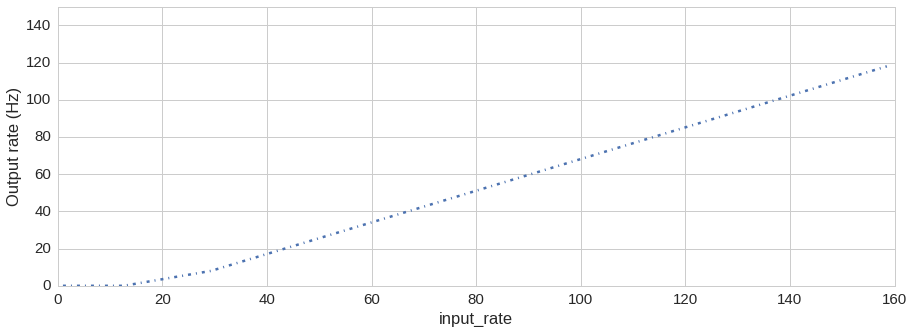

------------  weight  -------------


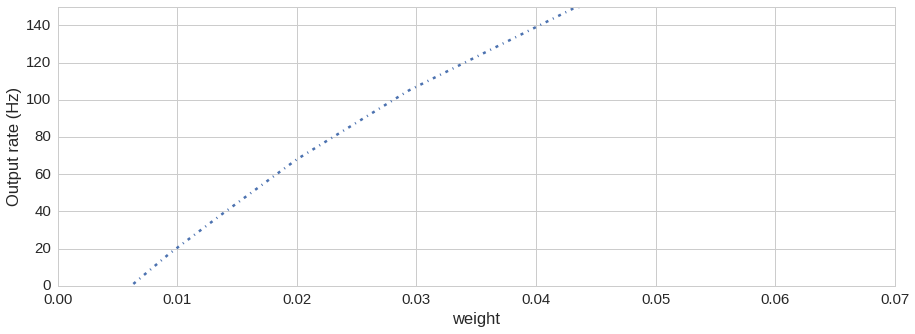

------------  syn_delay  -------------


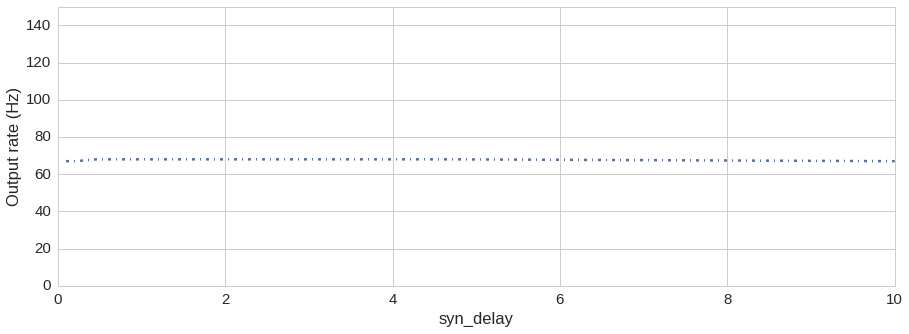

------------  tau_m  -------------


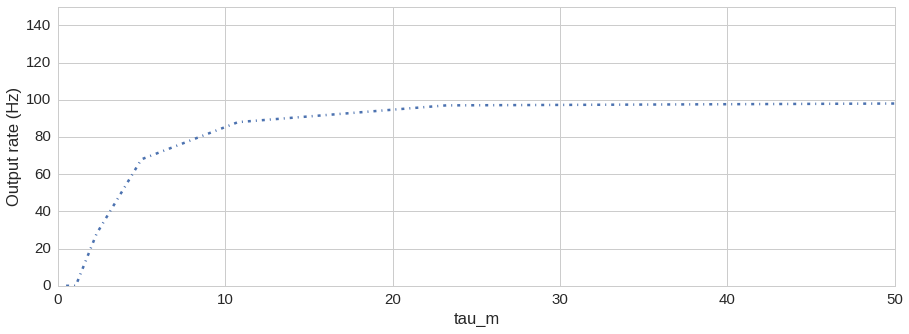

------------  tau_syn_E  -------------


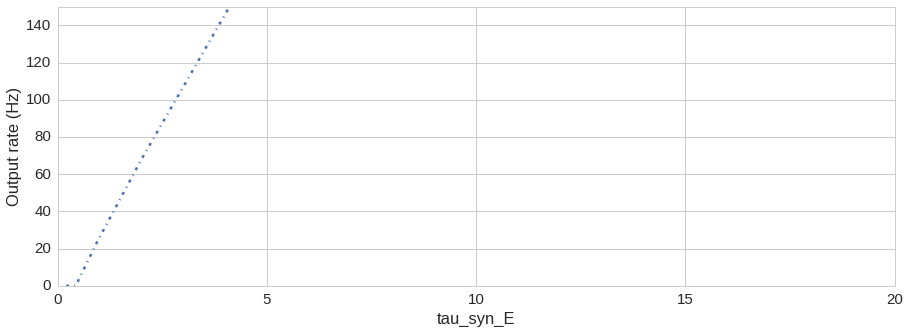

------------  tau_syn_I  -------------


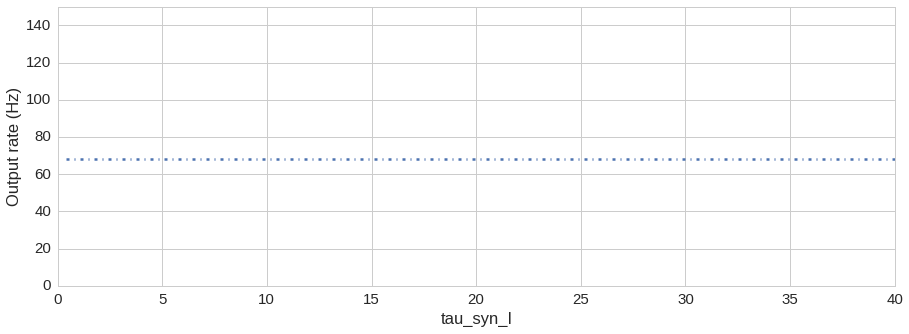

------------  e_rev_E  -------------


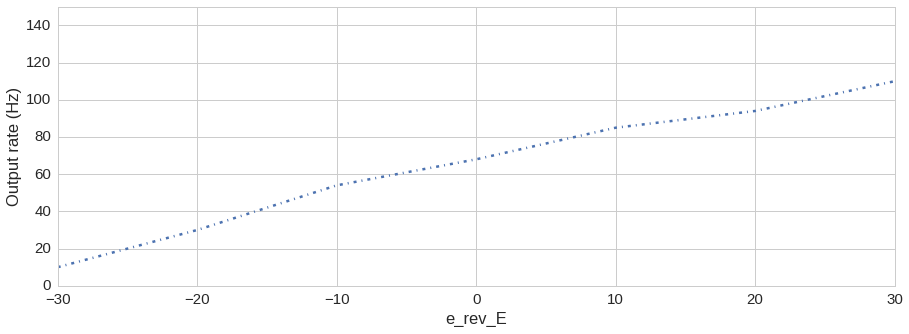

------------  e_rev_I  -------------


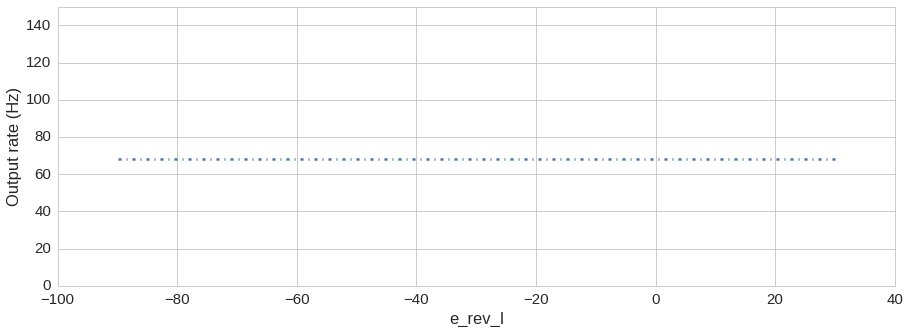

------------  tau_refrac  -------------


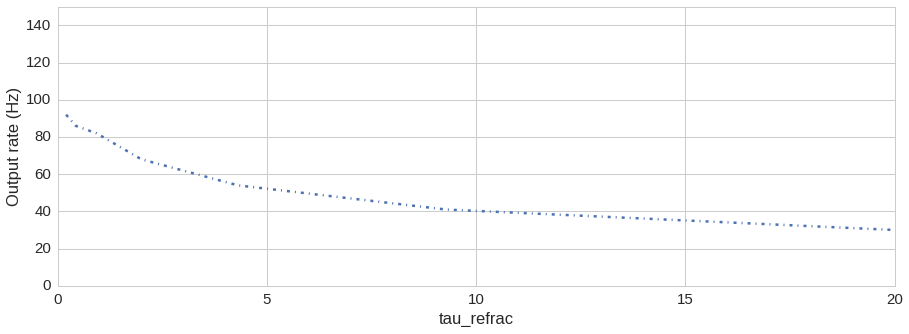

------------  v_rest  -------------


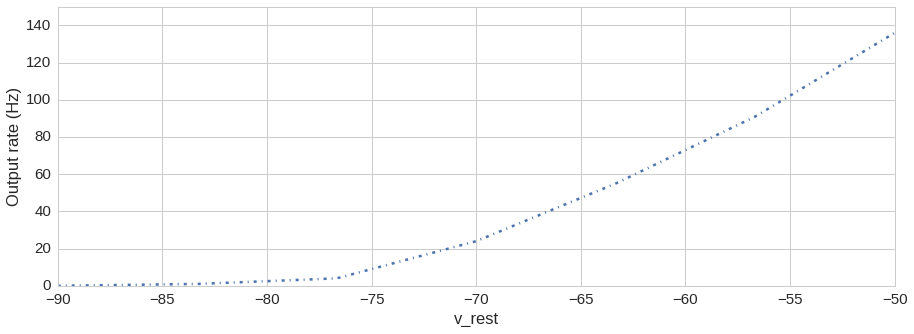

------------  v_reset  -------------


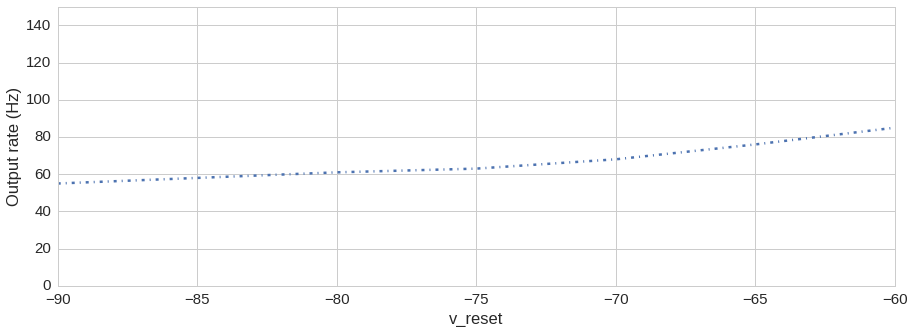

------------  v_thresh  -------------


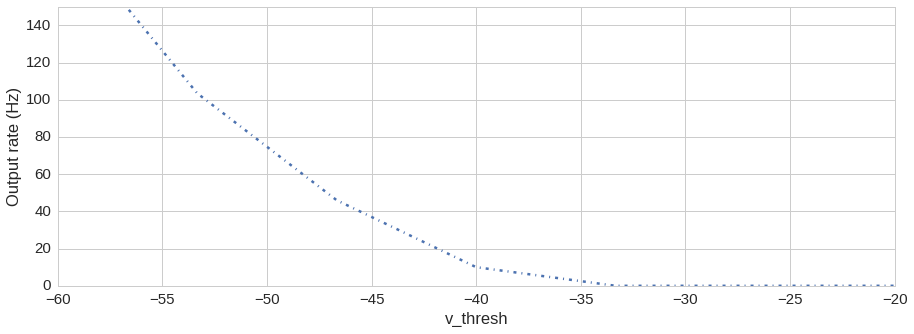

------------  cm  -------------


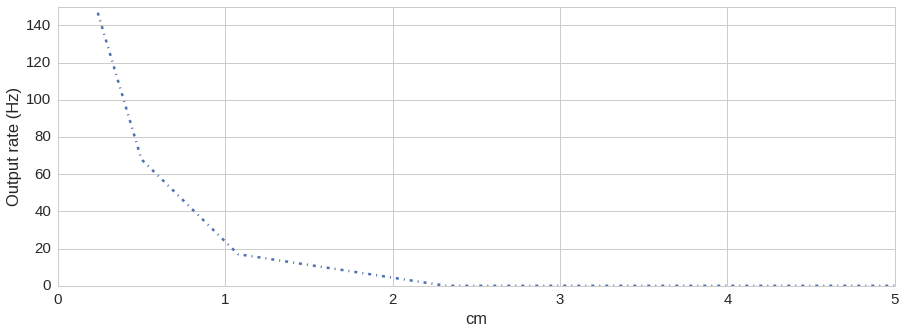

In [8]:
paramRole(7)